In [16]:
from langgraph.graph import StateGraph ,START, END
from typing import TypedDict,Annotated,Literal
from pydantic import BaseModel,Field
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage,SystemMessage  
import operator


In [ ]:
import os
os.environ["GOOGLE_API_KEY"] = "Api-Key"
 



In [18]:
generator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0.5)
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0.6)
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0.7)

In [19]:
from pydantic import BaseModel,Field

class PostEvaluation(BaseModel):
    evaluation:Literal["approved","needs_improvement"] = Field(..., description="The evaluation result indicating whether the post is approved or rejected.")
    score: float = Field(...,ge=0, le=10, description="A score between 0 and 10 indicating the quality of the post.")
    feedback: str = Field(..., description="Constructive feedback on how to improve the post.")

In [20]:
structured_evaluaator_llm = evaluator_llm.with_structured_output(PostEvaluation)

In [ ]:

class PostState(TypedDict):
    topic: str
    post: str
    evaluation: Literal["approved","needs_improvement"]
    feedback: str
    iteration:int
    max_iterations:int
    
    post_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]
    


In [ ]:
def generator_post(state: PostState) :
     # prompt
    messages = [
        SystemMessage(content="You are a Senior software Engineer ,an IT professional and a linkidin influencer."),
        HumanMessage(content=f"""
        Write a short, Technical, and impactful post on the topic: "{state['topic']}".

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational tech ,impacts , irony, sarcasm, or cultural references.
        - Think in technical logic, punchlines, or relatable takes.
        - Use simple,yet professional tone
        - Avoid buzzwords and jargon.
        - Make it engaging and thought-provoking.""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'post': response, 'post_history': [response]}

In [ ]:
def evaluate_post(state: PostState) :
    # prompt
    messages = [
        SystemMessage(content="You are a Senior software Engineer ,an IT professional and a linkidin influencer."),
        HumanMessage(content=f"""
        Evaluate the following LinkedIn post for technical accuracy, engagement, and relevance to the topic "{state['topic']}":

        Post: "{state['post']}"

        Provide your evaluation as either "approved" or "needs_improvement", along with specific feedback for improvement if needed.

        Rules:
        - Be concise and specific.
        - Focus on technical accuracy and engagement.
        - Avoid generic feedback.
       
        Auto-reject if:
        - It exceeds 280 characters
        - It reads like a traditional setup-punchline joke
        - Dont end with generic, throwaway, or deflating lines that weaken Technical superiority of the post.

        # Respond ONLY in structured format:
        - evaluation: "approved" or "needs_improvement"  
        - feedback: One paragraph explaining the strengths and weaknesses """)
    ]
    # send evaluator_llm
    response = structured_evaluaator_llm.invoke(messages)
    # return evaluation and feedback
    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [ ]:
def optimize_post(state: PostState):
    messages = [
        SystemMessage(content="You punch up Posts for virality and Techniciality based on given feedback."),
        HumanMessage(content=f"""
        Improve the post based on this feedback:
        "{state['feedback']}"

        Topic: "{state['topic']}"
        Original Post:
        {state['post']}
        Re-write it as a short, viral-worthy post. Avoid buzzwords stay under 280 characters.""")  ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'post': response, 'iteration': iteration, 'post_history': [response]}

In [25]:
def rout_evaluation(state: PostState):
    if state['evaluation'] == 'approved' or state['iteration']>=state['max_iterations']:
        return 'approved'
   
    else:
        return "needs_improvement" 

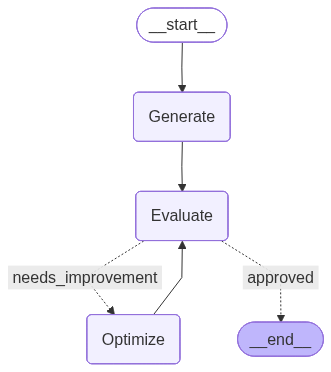

In [34]:
graph=StateGraph(PostState)
graph.add_node("Generate", generator_post)
graph.add_node("Evaluate", evaluate_post)
graph.add_node("Optimize", optimize_post)

graph.add_edge(START, "Generate")
graph.add_edge("Generate", "Evaluate")
graph.add_conditional_edges("Evaluate", rout_evaluation, {'approved': END, 'needs_improvement': "Optimize"})
graph.add_edge("Optimize", "Evaluate")
workflow = graph.compile()
workflow

In [33]:
initial_state = {
    "topic": "The Future is AI in Software Development",
    "iteration": 1,
    "max_iterations": 4
}
workflow.invoke(initial_state)

NameError: name 'state' is not defined